In [2]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag, zpd
from py_vlasov.wrapper import parallel_wrapper, disp_det, input_gen
from py_vlasov.dispersion_tensor import f_epsilon, f_chi, f_yn
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate

from py_vlasov.util import (pmass, emass, echarge, permittivity, permeability, cspeed, boltzmann)

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# k=1.
# kz = k
# kp = 0        
# betap = .1
# t_list=[1., 1., 1.]
# a_list=[1., 1., 1.]
# n_list=[1., 0.9, 0.1] 
# q_list=[1., -1., -1.]
# m_list=[1., 1/1836, 1/1836]
# nc_nh = n_list[1] / n_list[2]
# vdc = -10
# v_list=[0, vdc, -vdc * nc_nh]
# aol = 1/1000

# f = lambda wrel: real_imag(parallel_wrapper(
#     list_to_complex(wrel), kz, kp, betap, t_list, a_list, n_list,
#     q_list, m_list, v_list, method = 'numpy', aol=aol, pol='S'))
# # guess = 43 / aol
# guess = abs(k * v_list[2])
# print(guess)
# guess = 200 - 10j
# freq = scipy.optimize.fsolve(f, real_imag(guess))
# print(freq)

In [3]:
# kzs = np.linspace(1, 1000, 100)
# freqs = []
# guess = 43 / aol
# for kz in kzs:
#     f = lambda wrel: real_imag(
#         parallel_wrapper(
#             list_to_complex(wrel), kz, kp, betap, t_list, a_list, n_list,
#             q_list, m_list, v_list, method = 'numpy', aol=aol, pol='S'
#         )
#     )
#     freq = scipy.optimize.fsolve(f, real_imag(guess))
#     guess = list_to_complex(freq)
#     freqs.append(guess)
# freqs = np.array(freqs)
# k_ki = kzs * aol * np.sqrt(betap)

In [4]:
# plt.figure(figsize=[10, 8])
# plt.subplot(211)
# plt.plot(k_ki, freqs.real * aol)
# plt.plot()
# plt.subplot(212)
# plt.plot(k_ki, freqs.imag * aol)
# plt.ylim([-1, 1])

In [42]:
m_list = [1, 1836, 1836]
n_list = [1, 0.85, 0.15]
t_list = [1, 1, 10]
beta_0 = 1
beta_par_list = beta_0 * np.array(n_list) * t_list
vdc = -8
v_list = [0, vdc, -vdc * n_list[1] / n_list[2]]
aol = 1/2000
omega = aol * 43
k = 1

v0b_vc = v_list[2] * np.sqrt(2 * n_list[1] / m_list[1] / beta_par_list[1])
v0b_vh = v_list[2] * np.sqrt(2 * n_list[2] / m_list[2] / beta_par_list[2])
cond = v0b_vh**3 * n_list[2]
print(f'v0b_vc = {v0b_vc:.2g}')
print(f'v0b_vh = {v0b_vh:.2g}')
print(f'v0b_vh^3 * nb_ne = {cond:.2g}')

def es_det(k, omega, aol, m_list, beta_par_list, n_list, v_list):
    ret = 1
    for j in range(len(m_list)):
        zeta_j = (omega - k * v_list[j]) / k / np.sqrt(m_list[j] * beta_par_list[j] / n_list[j])
        ret -= n_list[j] ** 2 / k **2 / beta_par_list[j] / aol**2 * zpd(zeta_j)
    return ret


v0b_vc = 1.5
v0b_vh = 0.47
v0b_vh^3 * nb_ne = 0.016


In [43]:
guess = k * v_list[2] * (2 - 1.j)
print(guess)
f = lambda omega: real_imag(es_det(k, list_to_complex(omega), aol, m_list, beta_par_list, n_list, v_list))
freq = scipy.optimize.fsolve(f, real_imag(guess))
print(freq)

(90.66666666666667-45.333333333333336j)
[105.92853246 -49.66653413]


In [24]:
beam_kzs = np.logspace(0, 3.5, 300)
beam_freqs = []
guess = beam_kzs[0] * np.abs(v_list[2]) * (1.5 - 1.j)
for kz in beam_kzs:
    f = lambda omega: real_imag(es_det(kz, list_to_complex(omega), aol, m_list, beta_par_list, n_list, v_list))
    freq = scipy.optimize.fsolve(f, real_imag(guess))
    guess = list_to_complex(freq)
    beam_freqs.append(guess)
beam_freqs = np.array(beam_freqs)
beam_k_ki = beam_kzs * aol * np.sqrt(beta_par_list[0])
beam_theory = beam_kzs * np.abs(v_list[2])

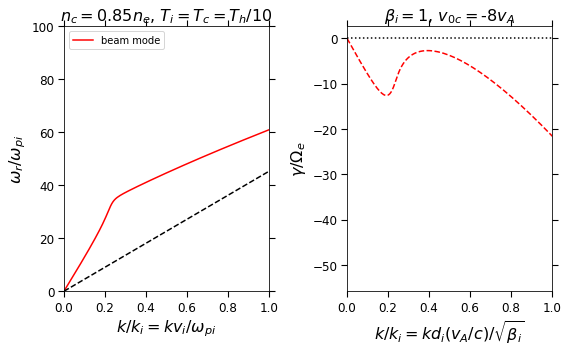

In [25]:
plt.figure(figsize=[8, 5])
plt.subplot(121)
plt.plot(beam_k_ki, beam_freqs.real * aol, 'r-', label='beam mode')
plt.plot(beam_k_ki, beam_theory * aol, 'k--')
plt.xlim([0, 1.])
plt.ylim([0, 100])
plt.xlabel(r'$k/k_i=kv_i/\omega_{pi}$')
plt.ylabel(r'$\omega_r/\omega_{pi}$')
plt.legend(loc='upper left')
plt.title(f'$n_c={n_list[1]}n_e$, $T_i=T_c=T_h/{t_list[2]}$')

plt.subplot(122)
plt.plot(beam_k_ki, beam_freqs.imag / 1836, 'r--')
plt.axhline(0, color='k', linestyle='dotted')
plt.xlim([0, 1.])
# plt.ylim([-10, 10])
plt.xlabel(r'$k/k_i=kd_i(v_A/c) / \sqrt{\beta_i}$')
plt.ylabel(r'$\gamma/\Omega_e$')
plt.title(r'$\beta_i=$' + f'{beta_0:.2g}, ' + r'$v_{0c}=$' + f'{v_list[1]}$v_A$')
plt.tight_layout()

In [46]:
m_list = [1, 1836, 1836]
n_list = [1, 0.85, 0.15]
t_list = [1, 1, 10]
beta_0 = 1
beta_par_list = beta_0 * np.array(n_list) * t_list
vdc = -8
v_list = [0, vdc, -vdc * n_list[1] / n_list[2]]
aol = 3e-4

v0b_vc = v_list[2] * np.sqrt(2 * n_list[1] / m_list[1] / beta_par_list[1])
v0b_vh = v_list[2] * np.sqrt(2 * n_list[2] / m_list[2] / beta_par_list[2])
cond = v0b_vh**3 * n_list[2]
print(f'v0b_vc = {v0b_vc:.2g}')
print(f'v0b_vh = {v0b_vh:.2g}')
print(f'v0b_vh^3 * nb_ne = {cond:.2g}')

langmuir_kzs = np.logspace(0, 3.8, 500)
langmuir_freqs = []
guess = 43 / aol
for kz in langmuir_kzs:
    f = lambda omega: real_imag(es_det(kz, list_to_complex(omega), aol, m_list, beta_par_list, n_list, v_list))
    freq = scipy.optimize.fsolve(f, real_imag(guess))
    guess = list_to_complex(freq)
    langmuir_freqs.append(guess)
langmuir_freqs = np.array(langmuir_freqs)
langmuir_k_ki = langmuir_kzs * aol * np.sqrt(beta_par_list[0])

v0b_vc = 1.5
v0b_vh = 0.47
v0b_vh^3 * nb_ne = 0.016


In [47]:
k = 1
guess = k * v_list[2] * (2 - 1j)
print(guess)
f = lambda omega: real_imag(es_det(k, list_to_complex(omega), aol, m_list, beta_par_list, n_list, v_list))
freq = scipy.optimize.fsolve(f, real_imag(guess))
print(freq)

(90.66666666666667-45.333333333333336j)
[105.92851103 -49.66652863]


In [48]:
beam_kzs = np.logspace(0, 3.8, 400)
beam_freqs = []
guess = beam_kzs[0] * np.abs(v_list[2]) * (2 - 1j)
for kz in beam_kzs:
    f = lambda omega: real_imag(es_det(kz, list_to_complex(omega), aol, m_list, beta_par_list, n_list, v_list))
    freq = scipy.optimize.fsolve(f, real_imag(guess))
    guess = list_to_complex(freq)
    beam_freqs.append(guess)
beam_freqs = np.array(beam_freqs)
beam_k_ki = beam_kzs * aol * np.sqrt(beta_par_list[0])
beam_theory = beam_kzs * np.abs(v_list[2])

In [49]:
ea_kzs = np.logspace(0, 3.8, 400)
ea_freqs = []
guess = ea_kzs[0] * np.abs(v_list[2]) * (3. - 1j)
for kz in ea_kzs:
    f = lambda omega: real_imag(es_det(kz, list_to_complex(omega), aol, m_list, beta_par_list, n_list, v_list))
    freq = scipy.optimize.fsolve(f, real_imag(guess))
    guess = list_to_complex(freq)
    ea_freqs.append(guess)
ea_freqs = np.array(ea_freqs)
ea_k_ki = ea_kzs * aol * np.sqrt(beta_par_list[0])
ea_theory = ea_kzs * np.abs(v_list[2])

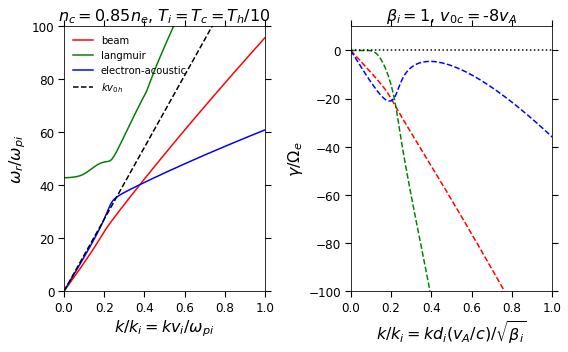

In [51]:
plt.figure(figsize=[8, 5])
plt.subplot(121)
plt.plot(beam_k_ki, beam_freqs.real * aol, 'r-', label='beam')
plt.plot(langmuir_k_ki, langmuir_freqs.real * aol, 'g', label='langmuir')
plt.plot(ea_k_ki, ea_freqs.real * aol, 'b', label='electron-acoustic')
plt.plot(beam_k_ki, 3 * beam_theory * aol, 'k--', label=r'$kv_{0h}$')
plt.xlim([0, 1.])
plt.ylim([0, 100])
plt.xlabel(r'$k/k_i=kv_i/\omega_{pi}$')
plt.ylabel(r'$\omega_r/\omega_{pi}$')
plt.legend(loc='upper left', frameon=False)
plt.title(f'$n_c={n_list[1]}n_e$, $T_i=T_c=T_h/{t_list[2]}$')

plt.subplot(122)
plt.plot(beam_k_ki, beam_freqs.imag / 1836, 'r--')
plt.plot(langmuir_k_ki, langmuir_freqs.imag / 1836, 'g--')
plt.plot(ea_k_ki, ea_freqs.imag / 1836, 'b--')
plt.axhline(0, color='k', linestyle='dotted')
plt.xlim([0, 1.])
plt.ylim([-100, 10])
plt.xlabel(r'$k/k_i=kd_i(v_A/c) / \sqrt{\beta_i}$')
plt.ylabel(r'$\gamma/\Omega_e$')
plt.title(r'$\beta_i=$' + f'{beta_0:.2g}, ' + r'$v_{0c}=$' + f'{v_list[1]}$v_A$')

plt.tight_layout()
# plt.savefig(
#     f'figure/electrostatic_betai={beta_0:.2g}_ncne={n_list[1]*100:.2g}_thtc={t_list[2]:.2g}_v0cva={v_list[1]:.2g}.png', 
#     dpi=100
# )


In [504]:
!open figure/electrostatic_betai\=1_ncne\=90_thtc\=10_v0cva\=-8.png

# visualize 1d f

In [510]:
# m_list = [1, 1836, 1836]
# n_list = [1, 0.9, 0.1]
# t_list = [1, 1, 1]
# beta_0 = 1.
# beta_par_list = beta_0 * np.array(n_list) * t_list
# vdc = -20
# v_list = [0, vdc, -vdc * n_list[1] / n_list[2]]
# aol = 1e-4

v0b_vc = v_list[2] * np.sqrt(2 * n_list[1] / m_list[1] / beta_par_list[1])
v0b_vh = v_list[2] * np.sqrt(2 * n_list[2] / m_list[2] / beta_par_list[2])
cond = v0b_vh**3 * n_list[2]
print(f'v0b_vc = {v0b_vc:.2g}')
print(f'v0b_vh = {v0b_vh:.2g}')
print(f'v0b_vh^3 * nb_ne = {cond:.2g}')

def f_c(vpar):
    return n_list[1] * np.exp(-(vpar - v_list[1] * np.sqrt(n_list[1] / m_list[1] / beta_par_list[1]))**2)
def f_h(vpar):
    tcpar_thpar = beta_par_list[1] / beta_par_list[2] * n_list[2] / n_list[1]
    # assume no anisotropy
    tcper_thper = tcpar_thpar
    return n_list[2] * tcpar_thpar * tcper_thper**2 * np.exp(-(vpar * np.sqrt(tcpar_thpar) - v_list[2] * np.sqrt(n_list[2] / m_list[2] / beta_par_list[2]))**2)

vpar_arr = np.linspace(-10, 10, 200)

fc_arr = np.array([f_c(v) for v in vpar_arr])
fh_arr = t_list[2] / t_list[1] * np.array([f_h(v) for v in vpar_arr])
# fh_arr = np.array([f_h(v) for v in vpar_arr])
f_arr = fc_arr +  fh_arr

v0b_vc = 2.4
v0b_vh = 0.75
v0b_vh^3 * nb_ne = 0.042


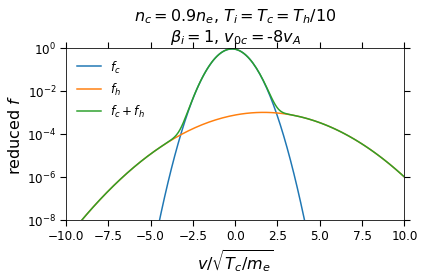

In [514]:
plt.plot(vpar_arr, fc_arr, label=r'$f_c$')
plt.plot(vpar_arr, fh_arr, label=r'$f_h$')
plt.plot(vpar_arr, f_arr, label=r'$f_c + f_h$')
plt.yscale('log')
plt.ylim([1e-8, 1])
plt.xlim([-10, 10])
plt.xlabel(r'$v/\sqrt{T_c/m_e}$')
plt.ylabel(r'reduced $f$')
title = f'$n_c={n_list[1]}n_e$, $T_i=T_c=T_h/{t_list[2]}$\n'
title += r'$\beta_i=$' + f'{beta_0:.2g}, ' + r'$v_{0c}=$' + f'{v_list[1]}$v_A$'
plt.title(title)
plt.legend(loc='upper left', frameon=False, fontsize=12)
plt.tight_layout()

# plt.savefig(
#     f'figure/f_betai={beta_0:.2g}_ncne={n_list[1]*100:.2g}_thtc={t_list[2]:.2g}_v0cva={v_list[1]:.2g}.png', 
#     dpi=100
# )
